# Object Detection with Street View House Numbers

This notebook illustrates how to build a deep CNN using Keras’ functional API to generate multiple outputs: one to predict how many digits are present, and five for the value of each in the order they appear.

## Imports & Settings

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, 
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from matplotlib.ticker import FuncFormatter

In [49]:
sns.set_style('whitegrid')

In [2]:
DATA_PATH = Path('images', 'svhn')

### Settings

In [3]:
IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
SEQ_LENGTH = 4
N_CLASSES = 11

## Load Data 

In [4]:
X_train = np.load(DATA_PATH / 'X_train.npy')
y_train = np.load(DATA_PATH / 'y_train.npy')

Removing the rare cases of 5-digit house numbers.

In [5]:
X_train = X_train[y_train[:, 0] < 5]
y_train = y_train[y_train[:, 0] < 5, :5]
y_train[:, 0] -= 1

In [6]:
X_test = np.load(DATA_PATH / 'X_test.npy')
y_test = np.load(DATA_PATH / 'y_test.npy')

In [7]:
X_test = X_test[y_test[:, 0] < 5]
y_test = y_test[y_test[:, 0] < 5, :5]
y_test[:, 0] -= 1

In [8]:
pd.DataFrame(y_train).nunique()

0     4
1    10
2    11
3    11
4    11
dtype: int64

In [9]:
y_train.shape

(33392, 5)

## Best Architecture

[Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks](https://arxiv.org/abs/1312.6082), Goodfellow, et al, 2014

In [10]:
digit_pos = {1: [4, 14], 2: [14, 25], 3: [25, 36], 4: [36, 47]}

In [11]:
def weighted_accuracy(y_true, y_pred):
    n_digits_pred = K.argmax(y_pred[:, :SEQ_LENGTH], axis=1)

    digit_preds = {}
    for digit, (start, end) in digit_pos.items():
        digit_preds[digit] = K.argmax(y_pred[:, start:end], axis=1)
    preds = tf.dtypes.cast(tf.stack((n_digits_pred,
                                     digit_preds[1],
                                     digit_preds[2],
                                     digit_preds[3],
                                     digit_preds[4]), axis=1), tf.float32)

    return K.mean(K.sum(tf.dtypes.cast(K.equal(y_true, preds), tf.int64), axis=1) / 5)

In [12]:
def weighted_entropy(y_true, y_pred):
    cce = tf.keras.losses.SparseCategoricalCrossentropy()
    n_digits = y_pred[:, :SEQ_LENGTH]

    digits = {}
    for digit, (start, end) in digit_pos.items():
        digits[digit] = y_pred[:, start:end]
    return (cce(y_true[:, 0], n_digits) +
            cce(y_true[:, 1], digits[1]) +
            cce(y_true[:, 2], digits[2]) +
            cce(y_true[:, 3], digits[3]) +
            cce(y_true[:, 4], digits[4])) / 5

In [13]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg16.trainable = False
x = vgg16.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
n_digits = Dense(SEQ_LENGTH, activation='softmax', name='n_digits')(x)
digit1 = Dense(N_CLASSES-1, activation='softmax', name='d1')(x)
digit2 = Dense(N_CLASSES, activation='softmax', name='d2')(x)
digit3 = Dense(N_CLASSES, activation='softmax', name='d3')(x)
digit4 = Dense(N_CLASSES, activation='softmax', name='d4')(x)
predictions = Concatenate()([n_digits, digit1, digit2, digit3, digit4])

model = Model(inputs=vgg16.input, outputs=predictions)

In [14]:
model.compile(optimizer='adam',
              loss=weighted_entropy,
              metrics=[weighted_accuracy])

As a result, the model produces five distinct outputs that we can evaluate.

## Define Callbacks

In [15]:
svhn_path = 'models/svhn.cnn.weights.best.hdf5'
checkpointer = ModelCheckpoint(filepath=svhn_path, 
                               verbose=1, 
                               monitor='val_weighted_accuracy',
                               save_best_only=True)

In [16]:
early_stopping = EarlyStopping(monitor='val_weighted_accuracy', 
                               patience=5)

## Train Transfer Model

In [17]:
epochs = 50

In [18]:
history = model.fit(x=X_train,
                    y=y_train,
                    validation_split=.1,
                    batch_size=32,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[checkpointer, early_stopping])

Train on 30052 samples, validate on 3340 samples
Epoch 1/50
29920/30052 [============================>.] - ETA: 0s - loss: 1.0639 - weighted_accuracy: 0.6419
Epoch 00001: val_weighted_accuracy improved from -inf to 0.66972, saving model to models/svhn.cnn.weights.best.hdf5
30052/30052 [==============================] - 11s 369us/sample - loss: 1.0636 - weighted_accuracy: 0.6420 - val_loss: 0.9703 - val_weighted_accuracy: 0.6697
Epoch 2/50
29888/30052 [============================>.] - ETA: 0s - loss: 0.9259 - weighted_accuracy: 0.6846
Epoch 00002: val_weighted_accuracy improved from 0.66972 to 0.68532, saving model to models/svhn.cnn.weights.best.hdf5
30052/30052 [==============================] - 9s 301us/sample - loss: 0.9255 - weighted_accuracy: 0.6847 - val_loss: 0.9290 - val_weighted_accuracy: 0.6853
Epoch 3/50
29920/30052 [============================>.] - ETA: 0s - loss: 0.8795 - weighted_accuracy: 0.6994
Epoch 00003: val_weighted_accuracy improved from 0.68532 to 0.69040, savin

### Evaluate Results

In [19]:
metrics = pd.DataFrame(history.history)
initial_epochs = len(metrics)

In [20]:
y_pred = model.predict(X_test, verbose=1)

13066/13066 [==============================] - 2s 182us/sample


In [21]:
n_digits = y_pred[:, :SEQ_LENGTH]
digits = {}
for digit, (start, end) in digit_pos.items():
    digits[digit] = y_pred[:, start:end]

In [22]:
(y_test[:, 0] == np.argmax(n_digits, axis=1)).sum()/len(n_digits)

0.8209092300627583

In [23]:
# pd.DataFrame(result.history)[['val_dense_{}_acc'.format(i) for i in range(1, 7)]].plot();

In [24]:
confusion_matrix(y_true=y_test[:, 0], y_pred=np.argmax(n_digits, axis=1))

array([[1911,  554,   18,    0],
       [ 408, 7226,  705,   17],
       [  16,  434, 1513,  118],
       [   0,    4,   66,   76]])

In [26]:
accuracy = np.zeros_like(y_test)
accuracy[:, 0] = (y_test[:, 0] == np.argmax(n_digits, axis=1))
for i in range(1, 5):
    accuracy[:, i] = (y_test[:, i] == np.argmax(digits[i], axis=1))

In [30]:
acc_by_output = {}
for i in range(5):
    acc_by_output[i] = accuracy[:, i].sum()/accuracy[:, i].shape[0]

In [32]:
acc_up_to_out = {}
for i in range(1, 6):
    r = accuracy[:, :i].all(1)
    acc_up_to_out[i-1] = r.sum()/r.shape[0]

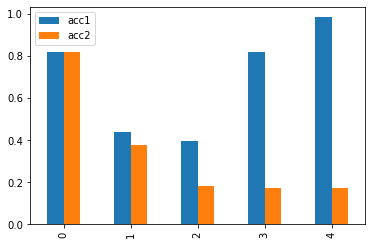

In [33]:
pd.DataFrame({'acc1': acc_by_output, 'acc2': acc_up_to_out}).plot.bar();

## Fine Tune VGG16 weights

In [34]:
vgg16.trainable = True
# Fine-tune from this layer onwards
start_fine_tuning_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [35]:
model.compile(optimizer='adam',
              loss=weighted_entropy,
              metrics=[weighted_accuracy])

In [36]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [39]:
history_fine_tune = model.fit(x=X_train,
                              y=y_train,
                              validation_split=.1,
                              batch_size=32,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              callbacks=[early_stopping])

Train on 30052 samples, validate on 3340 samples
Epoch 14/64
30052/30052 [==============================] - 21s 690us/sample - loss: 1.2374 - weighted_accuracy: 0.5860 - val_loss: 1.6906 - val_weighted_accuracy: 0.5037
Epoch 15/64
30052/30052 [==============================] - 19s 638us/sample - loss: 1.0102 - weighted_accuracy: 0.6569 - val_loss: 1.3011 - val_weighted_accuracy: 0.6125
Epoch 16/64
30052/30052 [==============================] - 19s 643us/sample - loss: 0.7620 - weighted_accuracy: 0.7414 - val_loss: 0.9194 - val_weighted_accuracy: 0.7199
Epoch 17/64
30052/30052 [==============================] - 19s 640us/sample - loss: 0.5864 - weighted_accuracy: 0.8040 - val_loss: 0.5391 - val_weighted_accuracy: 0.8170
Epoch 18/64
30052/30052 [==============================] - 19s 641us/sample - loss: 0.4877 - weighted_accuracy: 0.8389 - val_loss: 0.6261 - val_weighted_accuracy: 0.8101
Epoch 19/64
30052/30052 [==============================] - 19s 638us/sample - loss: 0.3921 - weighted

In [40]:
metrics_tuned = metrics.append(pd.DataFrame(history_fine_tune.history), ignore_index=True)

In [43]:
metrics_tuned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loss                   37 non-null     float64
 1   weighted_accuracy      37 non-null     float64
 2   val_loss               37 non-null     float64
 3   val_weighted_accuracy  37 non-null     float64
dtypes: float64(4)
memory usage: 1.3 KB


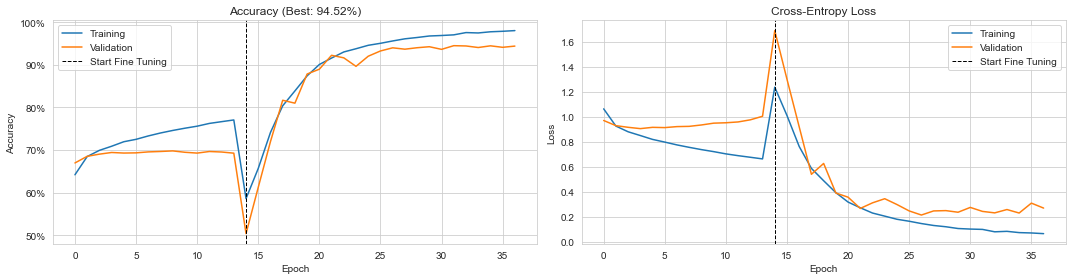

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['weighted_accuracy', 'val_weighted_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_weighted_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(14, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
fig.tight_layout()
fig.savefig('figures/transfer_learning_svhn');